In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# SWIFT PAT+OBS: Produce figure 9

## I/O data

In [2]:
simulations = {
    'case R': 'internal.ipa.wrf',
    'case An': 'internal.ipa.obs.allT',
    'case A1': 'internal.ipa.obs.Tassim',
    'case A0': 'internal.ipa.obs.noT',
}

In [3]:
datadir = '/scratch/dallaert/profile_assimilation_obs'

In [4]:
save_figures = False
figname_prefix = 'results_A'

## Some definitions

In [5]:
# Height at which spectra are calculated
TTU_tower_height = 74.7
simulated_height = 75.001

In [6]:
# Number of bins to average spectra over
Ndecades = 5
bins_per_decade = 8

## Prepare environment

In [7]:
import sys
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
# Manually adding path to mmctools repository to PYTHONPATH
sys.path.append(os.path.join(os.environ['HOME'],'tools','a2e-mmc'))

from mmctools.mmctools.plotting import plot_spectrum
from mmctools.mmctools.helper_functions import power_spectral_density

In [9]:
from helper_functions import sim_style, my_fieldlabels

In [10]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['axes.titlesize']  = 16

## Load simulation data

Load simulation data

In [11]:
%%time    
df_full_spectra = {}
for name,sim in simulations.items():
    print('Reading '+name)
    df_full_spectra[name] = xr.open_dataset(os.path.join(datadir,sim,'probe1_full_spectra.nc')).to_dataframe()

Reading case R
Reading case An
Reading case A1
Reading case A0
CPU times: user 225 ms, sys: 56.2 ms, total: 281 ms
Wall time: 367 ms


Calculate bin averages

In [12]:
Nbin = Ndecades * bins_per_decade
fbin=np.logspace(-5,0,num=2*Nbin+1)[1::2]

In [13]:
df_binned={}
for sim in simulations:
    tmp = df_full_spectra[sim].xs('2013-11-08 12:00:00',level='datetime').xs(simulated_height,level='height')
    # Average over exponentially increasing bin sizes
    df_binned[sim]=tmp.groupby(pd.cut(tmp.index, np.logspace(-5,0,num=Nbin+1), include_lowest=False)).mean()
    df_binned[sim].index = fbin
    df_binned[sim].dropna(inplace=True)

## Load reference data

Reference data:
- **TTU tower (1 Hz data):** Data from the TTU meteorological tower. Dataset generated in [process_TTU_tower.ipynb](https://github.com/a2e-mmc/assessment/blob/master/datasets/SWiFT/process_TTU_tower.ipynb)

In [14]:
from helper_functions import load_TTU_tower_1Hz_reference_data, reindex_if_needed

Load reference data

In [15]:
%time tower = load_TTU_tower_1Hz_reference_data(os.path.join(datadir,'referenceData','TTU_tilt_corrected_20131108-09.csv'))

CPU times: user 3.33 s, sys: 315 ms, total: 3.65 s
Wall time: 3.67 s


Calculate spectrum

In [16]:
%%time
# Reindex in case some timestamps are missing
tower = reindex_if_needed(tower)

# Calculate spectrum
tower_spectra = power_spectral_density(tower.xs(TTU_tower_height,level='height').loc[:,['wspd','w','theta']],
                                 tstart=pd.to_datetime('2013-11-08 12:00:00'),
                                 interval='24h',
                                 window_size='24h',
                                 window_type="hann"
)
tower_spectra['datetime'] = pd.to_datetime('2013-11-08 12:00:00')
tower_spectra['height'] = TTU_tower_height

tower_spectra = tower_spectra.reset_index().set_index(['datetime','height','frequency']).sort_index()

CPU times: user 2.13 s, sys: 746 ms, total: 2.87 s
Wall time: 2.75 s


Calculate bin averages

In [17]:
tmp = tower_spectra.xs('2013-11-08 12:00:00',level='datetime').xs(TTU_tower_height,level='height')
tower_binned = tmp.groupby(pd.cut(tmp.index, np.logspace(-5,0,num=Nbin+1), include_lowest=False)).mean()
tower_binned.index = fbin
tower_binned.dropna(inplace=True)

# Generate Figure 9: Full turbulent spectra (diurnal)

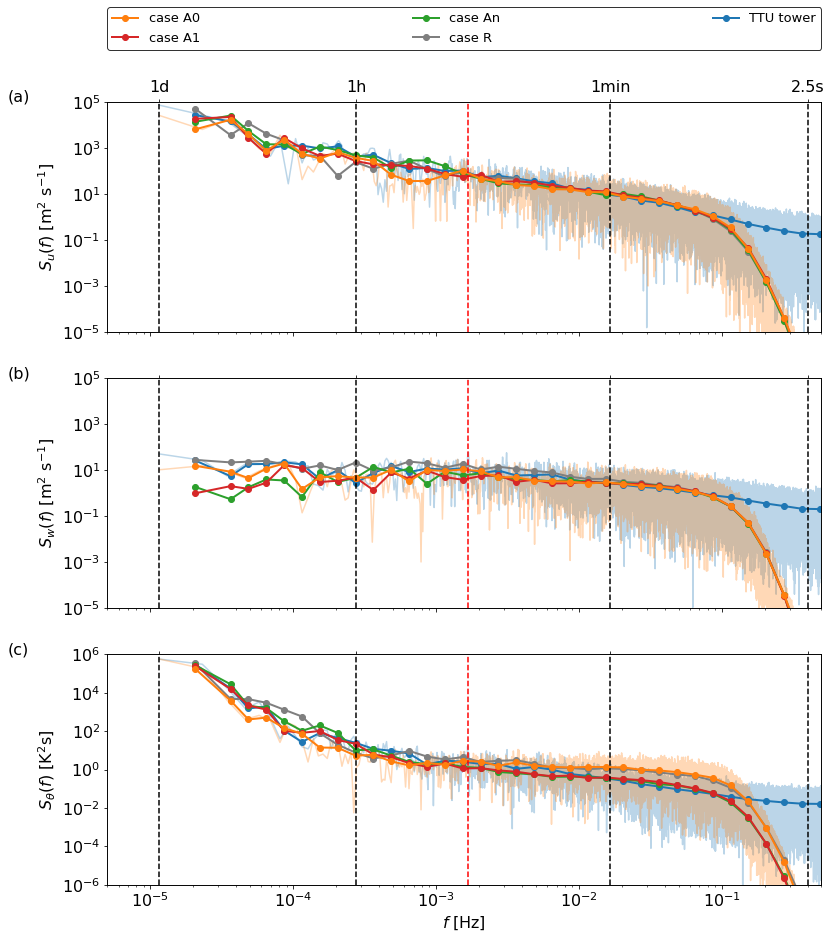

In [18]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(12.8,14.4))
_ = plot_spectrum(
    datasets={
        'TTU tower': tower_spectra,
    },
    fields=['wspd','w','theta'],height=74.7,alpha=0.3,fig=fig,ax=ax,showlegend=False,
    fieldlimits={'wspd':[1.e-5,1.e5],'w':[1.e-5,1.e5],'theta':[1.e-6,1.e6]},
    fieldlabels={'wspd':r'$S_u(f)$ [m$^2$ s$^{-1}$]','w':r'$S_w(f)$ [m$^2$ s$^{-1}$]','theta':r'$S_\theta(f)$ [K$^2$s]'}
)
_ = plot_spectrum(
    datasets={
        'case A0': df_full_spectra['case A0']
    },
    fields=['wspd','w','theta'],height=75.001,alpha=0.3,fig=fig,ax=ax,showlegend=False,
    fieldlimits={'wspd':[1.e-5,1.e5],'w':[1.e-5,1.e5],'theta':[1.e-6,1.e6]},
    fieldlabels={'wspd':r'$S_u(f)$ [m$^2$ s$^{-1}$]','w':r'$S_w(f)$ [m$^2$ s$^{-1}$]','theta':r'$S_\theta(f)$ [K$^2$s]'}
)
_ = plot_spectrum(
    datasets={
        'TTU tower': tower_binned,
        **df_binned
    },
    fields=['wspd','w','theta'],height=75.001,fig=fig,ax=ax,
    fieldlabels={'wspd':r'$S_u(f)$ [m$^2$ s$^{-1}$]','w':r'$S_w(f)$ [m$^2$ s$^{-1}$]','theta':r'$S_\theta(f)$ [K$^2$s]'},
    datasetkwargs={
        'TTU tower':{'linestyle':'-','color':'tab:blue','linewidth':2},
        **sim_style
    },
    marker='o'
)
for axi in ax:
    #ax[0].set_ylim([1.e-5,1.e5])
    axi.set_xlim([5.e-6,0.5])

# Set ticks in time period axis
time_tick_labels = ['2.5s','1min','1h','1d']
time_ticks = pd.to_timedelta(time_tick_labels).total_seconds().values
for axi in ax:
    for time in time_ticks:
        axi.axvline(1/time,color='k',ls='--')
    axi.axvline(1/600,color='r',ls='--') #Driving time scale
    axi.tick_params(axis='x', labelsize=16)

for i,axi in enumerate(ax):
    ax2 = axi.twiny()
    ax2.set_xscale('log')
    ax2.set_xlim((1/axi.get_xlim()[0],1/axi.get_xlim()[1]))
    ax2.set_xticks(time_ticks)
    ax2.set_xticks([], minor=True)
    if i==0:
        ax2.set_xticklabels(time_tick_labels,fontsize=16)
        
#Place legend at the top
handles, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()

leg = fig.legend(handles[-1::-1], labels[-1::-1], loc = 'lower left', bbox_to_anchor = (.125,.93,.775,0.0),
         borderaxespad=0,ncol=3,fontsize=13,
         bbox_transform = plt.gcf().transFigure,mode='expand')
leg.get_frame().set_edgecolor('k')

#fs = np.logspace(-3,-1,10)
#ax[0].loglog(fs,1e5*(fs/fs[0])**(-5/3),'--k')
#ax[0].loglog(fs,1e5*(fs/fs[0])**(-1),'--r')

#Subfigure labels
for i,axi in enumerate(ax):
    axi.text(-0.14,1.0,'('+chr(i+97)+')',transform=axi.transAxes,size=16)

#Save figure
if save_figures:
    figname = figname_prefix+'_full_spectrum'
    plt.savefig(os.path.join('Figures',figname+'.png'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.eps'),bbox_inches='tight')
    plt.savefig(os.path.join('Figures',figname+'.pdf'),bbox_inches='tight')